In [1]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D
from transformers import LayoutLMTokenizer, LayoutLMForSequenceClassification, AdamW

In [2]:
dataset_path = "../input/document-classification-dataset"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'resume': 0, 'email': 1, 'scientific_publication': 2}

In [3]:
images = []
labels = []

for label in os.listdir(dataset_path):
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])
data = pd.DataFrame({'image_path': images, 'label': labels})

train_data, valid_data = train_test_split(data, test_size=0.09, random_state=0, stratify=data.label)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

150 training examples, 15 validation examples


,image_path,label
0,../input/document-classification-dataset/resum...,resume
1,../input/document-classification-dataset/resum...,resume
2,../input/document-classification-dataset/resum...,resume
3,../input/document-classification-dataset/resum...,resume
4,../input/document-classification-dataset/resum...,resume


# Data Preparation

In [4]:
def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

In [5]:
def encode_training_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))

    # Truncation of token_boxes
    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes
    encoding['label'] = label2idx[example['label']]
    

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
training_features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

In [6]:
def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)
    dataset = dataset.map(apply_ocr)

    encoded_dataset = dataset.map(
        lambda example: encode_training_example(example), features=training_features
    )
    encoded_dataset.set_format(
        type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label']
    )
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
    batch = next(iter(dataloader))
    return dataloader

In [7]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

train_dataloader = training_dataloader_from_df(train_data)
valid_dataloader = training_dataloader_from_df(valid_data)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

  0%|          | 0/150 [00:00<?, ?ex/s]

  0%|          | 0/150 [00:00<?, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ex/s]

  0%|          | 0/15 [00:00<?, ?ex/s]

# Building the Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained(
    "microsoft/layoutlm-base-uncased", num_labels=len(label2idx)
)
model.to(device);

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

# Training

In [9]:
optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 3


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    #put the model in training mode
    model.train()
    for batch in tqdm(train_dataloader):
        labels = batch["label"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == labels).float().sum()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
    training_accuracy = 100 * training_correct / len(train_data)
    print("Training accuracy:", training_accuracy.item())  
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        labels = batch["label"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == labels).float().sum()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])
    validation_accuracy = 100 * validation_correct / len(valid_data)
    print("Validation accuracy:", validation_accuracy.item())  

Epoch: 0


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/150 [00:00<?, ?it/s]

Training Loss: 39.646210711449385
Training accuracy: 92.66667175292969


  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.31319389399141073
Validation accuracy: 100.00000762939453
Epoch: 1


  0%|          | 0/150 [00:00<?, ?it/s]

Training Loss: 9.257709607714787
Training accuracy: 97.33333587646484


  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 18.899175220169127
Validation accuracy: 80.00000762939453
Epoch: 2


  0%|          | 0/150 [00:00<?, ?it/s]

Training Loss: 13.92363285832107
Training accuracy: 98.0


  0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.09139833925291896
Validation accuracy: 100.00000762939453


In [10]:
model.save_pretrained('saved_model/')

# Inference

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMForSequenceClassification.from_pretrained("saved_model")
model.to(device);

In [12]:
def encode_testing_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
  
    # Truncation of token_boxes
    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding

testing_features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

In [13]:
query_df = pd.DataFrame(
    {'image_path': ['../input/document-classification-dataset/email/doc_000042.png']}
)
query = Dataset.from_pandas(query_df)
query = query.map(apply_ocr)
query = query.map(lambda example: encode_testing_example(example), features=testing_features)
query.set_format(
    type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids']
)
query = torch.utils.data.DataLoader(query, batch_size=1, shuffle=True)
batch = next(iter(query))

outputs = model(
    input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
    attention_mask=batch["attention_mask"].to(device), 
    token_type_ids=batch["token_type_ids"].to(device)
)
preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
pred_labels

  0%|          | 0/1 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ex/s]

{'resume': 0.001984013943001628,
 'email': 0.9972844123840332,
 'scientific_publication': 0.0007315863622352481}

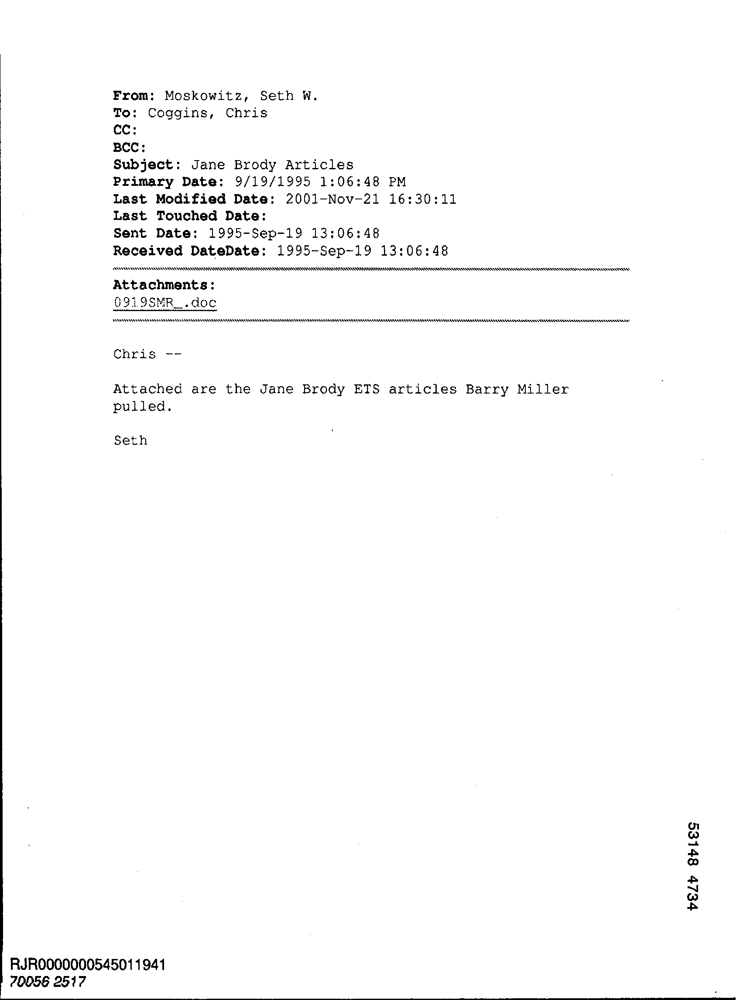

In [14]:
Image.open(query_df.values[0][0])